In [9]:
import os, math, time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tqdm.auto import tqdm

from common.config import (
    BASE_DIR,
    NUM_CLASSES,
    BATCH_SIZE,
    EPOCHS,
    WARMUP_EPOCHS,
    SEED,
    BASE_LEARNING_RATE,
    WD,
    SEED,
    DEVICE,
    WORKER_NUM,
    CLASS_NAMES,
    TRANSFORM,
    TRAIN_TRANSFORM,
    VAL_TRANSFORM,
    TRAIN_IMAGE_DIR,
    TRAIN_LABEL_DIR,
    VAL_IMAGE_DIR,
    VAL_LABEL_DIR,
    TEST_IMAGE_DIR,
    TEST_LABEL_DIR,
    LOG_DIR,
    TRAIN_LOG_DIR,
    TEST_LOG_DIR,
    MODEL_DIR,
    DROPOUT_RATE,
)
from common.utils import (
    set_seed,
    worker_init_fn,
    get_mean_std_from_weights,
    get_device,
    device_pretty,
    human_time,
    count_parameters,
    calculate_top_k_accuracy,
    calculate_f1_score,
    calculate_auroc,
    save_auroc_data,
    save_checkpoint,
)
from common.dataset import CustomDataset
from common.logger import Logger
from common.evaluate import evaluate_test_set, print_test_results

# initail seed 설정
set_seed(SEED)

# Check PyTorch version and CUDA availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name()}")

# Set device for computations
device = torch.device(DEVICE)
print(f"Using device: {device}")

set_seed 42
PyTorch version: 2.8.0
CUDA available: False
CUDA device count: 0
Using device: mps


In [10]:
import os, glob

print("CWD:", os.getcwd())
print("LABEL_DIR:", TRAIN_LABEL_DIR)
print("IMAGE_DIR:", TRAIN_IMAGE_DIR)
print("LABEL_DIR exists:", os.path.isdir(TRAIN_LABEL_DIR))
print("IMAGE_DIR exists:", os.path.isdir(TRAIN_IMAGE_DIR))

json_paths = glob.glob(os.path.join(TRAIN_LABEL_DIR, "**", "*.json"), recursive=True)
print("Found json files:", len(json_paths))

CWD: /Users/tykim/Desktop/work/SNU_2025_Deeplearning_project
LABEL_DIR: /Users/tykim/Desktop/work/SNU_2025_Deeplearning_project/data/train/라벨링데이터
IMAGE_DIR: /Users/tykim/Desktop/work/SNU_2025_Deeplearning_project/data/train/원천데이터
LABEL_DIR exists: True
IMAGE_DIR exists: True
Found json files: 12000


# 1. 데이터 셋 로드


In [11]:
# 1) 데이터 증강,변환(색 왜곡은 과하지 않게)
MODEL_FILE_NAME = "best_restnet_model.pth"

# MPS에서는 None, 나머지는 generator
generator = None if DEVICE == "mps" else torch.Generator(device=DEVICE)

train_dataset = CustomDataset(
    label_folder=TRAIN_LABEL_DIR, image_folder=TRAIN_IMAGE_DIR, transform=TRAIN_TRANSFORM
)
val_datatset = CustomDataset(
    label_folder=VAL_LABEL_DIR, image_folder=VAL_IMAGE_DIR, transform=VAL_TRANSFORM
)
test_datatset = CustomDataset(
    label_folder=TEST_LABEL_DIR, image_folder=TEST_IMAGE_DIR, transform=VAL_TRANSFORM
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKER_NUM,
    generator=generator,
    worker_init_fn=worker_init_fn,
)
val_loader = DataLoader(
    val_datatset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=WORKER_NUM,
    generator=generator,
)
test_loader = DataLoader(
    val_datatset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=WORKER_NUM,
    generator=generator,
)

Loading data: 100%|██████████| 1500/1500 [00:08<00:00, 168.40file/s]


# 2. 모델 설정 - ResNet101

## 각 모델별로 다르게 설정!!

In [12]:
# 2) 모델: ResNet101 - CNN 기반 모델
def create_model():
    weights = models.ResNet101_Weights.IMAGENET1K_V2
    model = models.resnet101(weights=weights)

    # 기존 분류기의 입력 차원 수 가져옴 (2048개)
    in_feats = model.fc.in_features

    # 마지막 분류기 교체: 입력 → 출력 선형 변환, 2048 → 15개
    model.fc = nn.Sequential(
        nn.Dropout(p=DROPOUT_RATE), nn.Linear(in_feats, NUM_CLASSES)
    )
    return model.to(device)

model = create_model()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 3. Optima, Scheduler, Scaler 설정

In [13]:
# 3) 손실/옵티마/스케줄러
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), lr=BASE_LEARNING_RATE, weight_decay=WD
)

def lr_lambda(current_epoch):
    if current_epoch < WARMUP_EPOCHS:
        return float(current_epoch + 1) / WARMUP_EPOCHS
    # cosine
    t = (current_epoch - WARMUP_EPOCHS) / max(1, (EPOCHS - WARMUP_EPOCHS))
    return 0.5 * (1 + math.cos(math.pi * t))


# 스케쥴러
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# 스케일러
# Mixed Precision Training 설정 (GPU에서만 사용)
if torch.cuda.is_available():
    scaler = torch.amp.GradScaler("cuda")
    print("✅ Mixed Precision Training enabled (GPU)")
else:
    scaler = None
    print("⚠️  Mixed Precision Training disabled (CPU mode)")

# Logger 설정
logger = Logger(LOG_DIR, "train_log_ResNet.json")

⚠️  Mixed Precision Training disabled (CPU mode)


# 4. 평가지표 변수 설정

In [14]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_top3_accuracies, val_top3_accuracies = [], []
train_aurocs, val_aurocs = [], []
train_f1_scores, val_f1_scores = [], []

best_val_loss = float("inf")
best_composite_score = 0.0  # 복합 점수 초기화
best_epoch = 0
early_stopping_counter = 0
patience = 20

# 학습 시작 시간
total_start_time = time.time()
print(
    f"Training started at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(total_start_time))}"
)

Training started at 2025-09-04 12:12:14


# 5. 모델 학습 함수 정의

In [15]:
def train_one_epoch(
    model, train_loader, criterion, optimizer, device, scaler=None, desc=None
):
    """한 에포크 학습"""
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_top3_correct = 0
    epoch_total = 0

    train_outputs = []
    train_labels = []

    iterator = train_loader
    if desc is not None:
        try:
            from tqdm.auto import tqdm

            iterator = tqdm(train_loader, desc=desc)
        except Exception:
            iterator = train_loader

    for images, labels in iterator:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        if scaler is not None:
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        batch_size = labels.size(0)
        epoch_total += batch_size
        epoch_correct += (preds == labels).sum().item()
        epoch_top3_correct += calculate_top_k_accuracy(outputs, labels, k=3)

        train_outputs.extend(outputs.detach().cpu().tolist())
        train_labels.extend(labels.detach().cpu().tolist())

    epoch_loss /= max(1, len(train_loader))
    epoch_acc = epoch_correct / max(1, epoch_total)
    epoch_top3_acc = epoch_top3_correct / max(1, epoch_total)

    return {
        "loss": epoch_loss,
        "accuracy": epoch_acc,
        "top3_accuracy": epoch_top3_acc,
        "outputs": train_outputs,
        "labels": train_labels,
    }


def validation_one_epoch(model, val_loader, criterion, device, desc=None):
    """한 에포크 검증"""
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_top3_correct = 0
    val_total = 0

    val_outputs = []
    val_labels = []

    iterator = val_loader
    if desc is not None:
        try:
            from tqdm.auto import tqdm

            iterator = tqdm(val_loader, desc=desc)
        except Exception:
            iterator = val_loader

    with torch.no_grad():
        for images, labels in iterator:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            batch_size = labels.size(0)
            val_total += batch_size
            val_correct += (preds == labels).sum().item()
            val_top3_correct += calculate_top_k_accuracy(outputs, labels, k=3)

            val_outputs.extend(outputs.detach().cpu().tolist())
            val_labels.extend(labels.detach().cpu().tolist())

    val_loss /= max(1, len(val_loader))
    val_acc = val_correct / max(1, val_total)
    val_top3_acc = val_top3_correct / max(1, val_total)

    return {
        "loss": val_loss,
        "accuracy": val_acc,
        "top3_accuracy": val_top3_acc,
        "outputs": val_outputs,
        "labels": val_labels,
    }

# 6. 모델 훈련

In [16]:
for epoch in range(EPOCHS):
    start_time = time.time()  # 에포크 시작 시간 기록

    # ===============================================
    # Training
    # ===============================================
    train_metrics = train_one_epoch(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        scaler=scaler,
        desc=f"Training Epoch {epoch+1}/{EPOCHS}",
    )

    train_losses.append(train_metrics["loss"])
    train_accuracies.append(train_metrics["accuracy"])
    train_top3_accuracies.append(train_metrics["top3_accuracy"])
    train_f1_scores.append(
        calculate_f1_score(
            torch.tensor(train_metrics["outputs"]),
            torch.tensor(train_metrics["labels"]),
        )
    )
    train_aurocs.append(
        calculate_auroc(
            torch.tensor(train_metrics["outputs"]),
            torch.tensor(train_metrics["labels"]),
        )
    )
    save_auroc_data(
        train_metrics["outputs"],
        train_metrics["labels"],
        epoch + 1,
        "train",
        TRAIN_LOG_DIR,
    )

    # ===============================================
    # Validation
    # ===============================================
    val_metrics = validation_one_epoch(
        model=model,
        val_loader=val_loader,
        criterion=criterion,
        device=device,
        desc="Validating",
    )

    val_losses.append(val_metrics["loss"])
    val_accuracies.append(val_metrics["accuracy"])
    val_top3_accuracies.append(val_metrics["top3_accuracy"])
    val_f1_scores.append(
        calculate_f1_score(torch.tensor(val_metrics["outputs"]), torch.tensor(val_metrics["labels"]))
    )
    val_aurocs.append(
        calculate_auroc(torch.tensor(val_metrics["outputs"]), torch.tensor(val_metrics["labels"]))
    )
    save_auroc_data(val_metrics["outputs"], val_metrics["labels"], epoch + 1, "val", TRAIN_LOG_DIR)

    # Scheduler
    scheduler.step()  # ReduceLROnPlateau 사용 시: scheduler.step(val_metrics["loss"])

    # 에포크 소요 시간 계산
    end_time = time.time()
    epoch_duration = end_time - start_time

    # 에포크 결과 출력
    print(
        f"[Epoch {epoch+1}/{EPOCHS}] "
        f"Time: {epoch_duration:.2f}s, "
        f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Train Top-3: {train_top3_accuracies[-1]:.4f}, Train F1: {train_f1_scores[-1]:.4f}, "
        f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}, Val Top-3: {val_top3_accuracies[-1]:.4f}, Val F1: {val_f1_scores[-1]:.4f}"
    )

    # 의료 이미지 분류에 최적화된 복합 점수 계산
    composite_score = (
        0.4 * val_accuracies[-1] +      # 40% - 정확도 (가장 중요)
        0.3 * val_aurocs[-1] +          # 30% - AUROC (의료 분류에서 중요)
        0.2 * val_f1_scores[-1] +       # 20% - F1 Score (클래스 불균형 고려)
        0.1 * (1 - val_losses[-1])      # 10% - Loss (낮을수록 좋음)
    )

    # 최고 성능 모델 저장
    if composite_score > best_composite_score:
        best_composite_score = composite_score
        best_epoch = epoch + 1
        early_stopping_counter = 0
        save_checkpoint(
            {
                "epoch": epoch + 1,  # 현재 에포크
                "state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss": train_losses[-1],
                "train_accuracy": train_accuracies[-1],
                "train_top3_accuracy": train_top3_accuracies[-1],
                "train_f1_score": train_f1_scores[-1],
                "train_auroc": train_aurocs[-1],
                "val_loss": val_losses[-1],
                "val_accuracy": val_accuracies[-1],
                "val_top3_accuracy": val_top3_accuracies[-1],
                "val_f1_score": val_f1_scores[-1],
                "val_auroc": val_aurocs[-1],
                "composite_score": composite_score,
                "epoch_duration": epoch_duration,
            },
            MODEL_DIR,
            MODEL_FILE_NAME,
        )
        print(f"🎯 New best model saved! Composite Score: {composite_score:.4f}")
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best epoch was {best_epoch}.")
        break

    # 로그 기록
    logger.log(
        {
            "epoch": epoch + 1,
            "train_loss": train_losses[-1],
            "train_accuracy": train_accuracies[-1],
            "train_top3_accuracy": train_top3_accuracies[-1],
            "train_f1_score": train_f1_scores[-1],
            "train_auroc": train_aurocs[-1],
            "val_loss": val_losses[-1],
            "val_accuracy": val_accuracies[-1],
            "val_top3_accuracy": val_top3_accuracies[-1],
            "val_f1_score": val_f1_scores[-1],
            "val_auroc": val_aurocs[-1],
            "composite_score": composite_score,
            "epoch_duration": epoch_duration,
        }
    )

Training Epoch 1/1:   0%|          | 0/375 [00:00<?, ?it/s]

AUROC data saved for train at epoch 1 to /Users/tykim/Desktop/work/SNU_2025_Deeplearning_project/logs/train_logs/train_auroc_data_epoch_1.json


Validating:   0%|          | 0/47 [00:00<?, ?it/s]

AUROC data saved for val at epoch 1 to /Users/tykim/Desktop/work/SNU_2025_Deeplearning_project/logs/train_logs/val_auroc_data_epoch_1.json
[Epoch 1/1] Time: 367.16s, Train Loss: 0.8561, Train Acc: 0.9061, Train Top-3: 0.9692, Train F1: 0.9062, Val Loss: 0.6174, Val Acc: 0.9853, Val Top-3: 0.9993, Val F1: 0.9852
Checkpoint saved at /Users/tykim/Desktop/work/SNU_2025_Deeplearning_project/model/best_restnet_model.pth
🎯 New best model saved! Composite Score: 0.9292
{
    "epoch": 1,
    "train_loss": 0.8561153197288514,
    "train_accuracy": 0.9060833333333334,
    "train_top3_accuracy": 0.9691666666666666,
    "train_f1_score": 0.906183872559606,
    "train_auroc": 0.9910330803571429,
    "val_loss": 0.6173684229242041,
    "val_accuracy": 0.9853333333333333,
    "val_top3_accuracy": 0.9993333333333333,
    "val_f1_score": 0.9851735303711732,
    "val_auroc": 0.9993319047619048,
    "composite_score": 0.929230768543719,
    "epoch_duration": 367.1574320793152,
    "timestamp": "2025-09-04

In [17]:
# 로그 저장
logger.save()

# 학습 종료 시간
total_end_time = time.time()
total_duration = total_end_time - total_start_time
print(
    f"Training completed at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(total_end_time))}"
)
print(f"Total training time: {total_duration:.2f}s")

Log saved to /Users/tykim/Desktop/work/SNU_2025_Deeplearning_project/logs/train_log_ResNet.json
Training completed at 2025-09-04 12:18:23
Total training time: 368.81s


# 7. Test 검증

In [18]:
# 체크포인트 로드
checkpoint = torch.load(os.path.join(MODEL_DIR, MODEL_FILE_NAME), weights_only=False)

# 체크포인트의 키들 확인
print("Checkpoint keys:", list(checkpoint.keys()))
print("State dict keys (first 10):", list(checkpoint["state_dict"].keys())[:10])

Checkpoint keys: ['epoch', 'state_dict', 'optimizer_state_dict', 'train_loss', 'train_accuracy', 'train_top3_accuracy', 'train_f1_score', 'train_auroc', 'val_loss', 'val_accuracy', 'val_top3_accuracy', 'val_f1_score', 'val_auroc', 'composite_score', 'epoch_duration']
State dict keys (first 10): ['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean']


Testing:   0%|          | 0/47 [00:00<?, ?it/s]


ResNet-101 - Final Test Results
Test Loss: 0.6174
Test Accuracy (Top-1): 0.9853
Test Accuracy (Top-3): 0.9993
Test F1-Score: 0.9852
Test AUROC: 0.9993


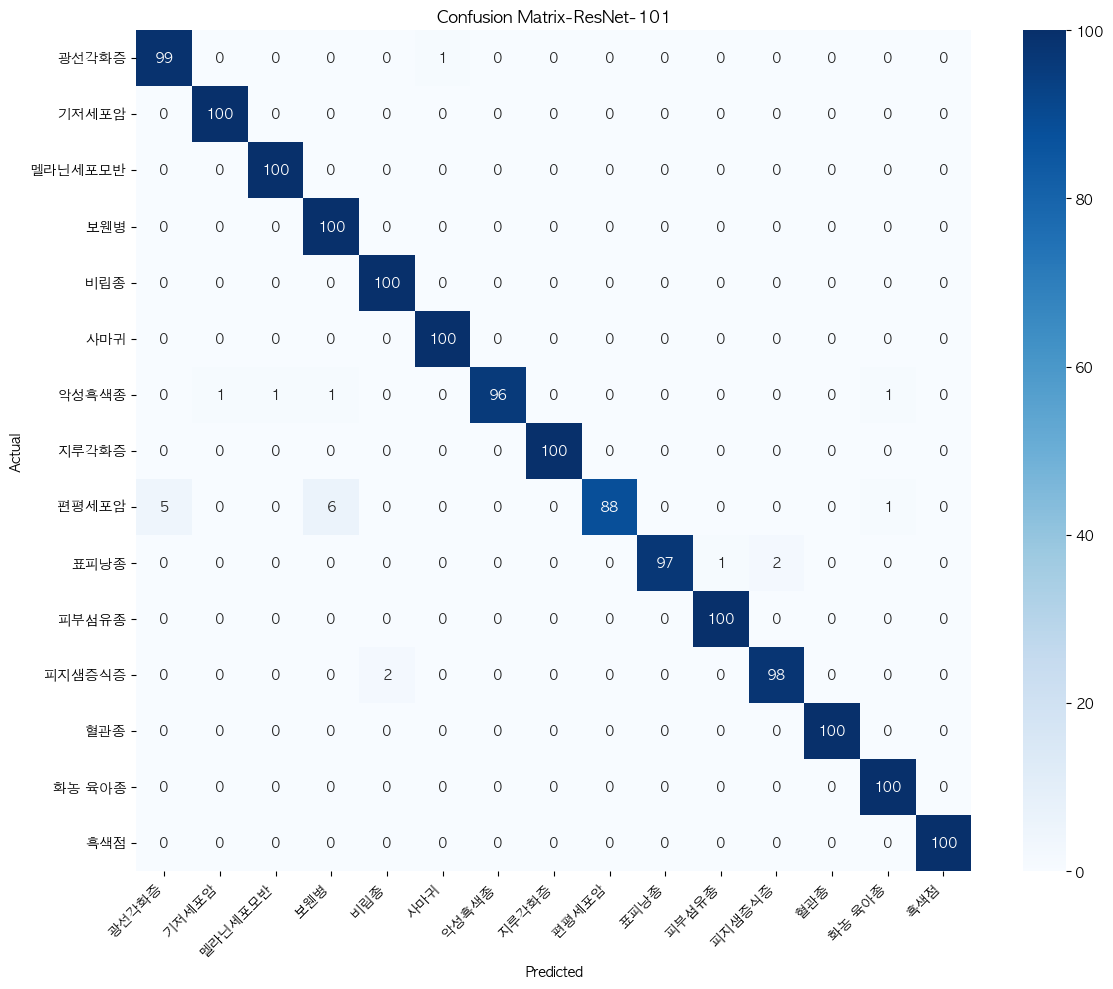

In [19]:
# 모델 생성 (기존 모델 정의 코드 필요)
model = create_model()

# 체크포인트에서 가중치 로드
model.load_state_dict(checkpoint["state_dict"])

# 평가 실행
results = evaluate_test_set(model, test_loader, criterion, device)
print_test_results(results, "ResNet-101")